In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from tqdm import tqdm

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sys.path.append("/home/labadmin/Github/BCI_analysis/BCI_analysis/")
# from pipeline.pipeline_align import get_aligned_data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# from plot_utils import rollingfun
from sklearn.decomposition import PCA

dlc_base_dir = os.path.abspath("../bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("../bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("../bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("../bucket/Data/Calcium_imaging/sessionwise_tba/")
plt_save_path = os.path.abspath("../Plots/")

mouse = "BCI_26"
FOV = "FOV_04"
camera = "side" 
session = "041022"

# from ..pipeline.pipeline_align import align_licks


In [8]:
def interpolate_ca_data(dlc_trial, F_trial, plot=False):
    x = np.linspace(0, dlc_trial.shape[0], F_trial.shape[1])
    xnew = np.arange(0, dlc_trial.shape[0])
    F_ret = np.zeros((F_trial.shape[0], dlc_trial.shape[0]))
    for i in range(F_trial.shape[0]):
        y = F_trial[i, :]
        f = interpolate.interp1d(x, y)
        ynew = f(xnew)
        F_ret[i, :] = ynew
    if plot:
        plt.plot(x, y, 'o', xnew, ynew, '-')
        plt.show()
    return F_ret

In [122]:

bpod_filepath = os.path.join(bpod_path, mouse, session+"-bpod_zaber.npy")
bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()
behavior_movie_names = bpod_data['behavior_movie_name_list'][:-1]
trial_start_times = bpod_data['trial_start_times']

ca_data = np.load(os.path.join(sessionwise_data_path, mouse, mouse+"-"+session+"-"+FOV+".npy"), allow_pickle=True).tolist()
F = ca_data['F_sessionwise']
fs = ca_data['sampling_rate']
lick_times = ca_data['lick_times']
reward_times = ca_data['reward_times']
trial_times = ca_data['trial_times']

with open(os.path.join(suite2p_path, mouse, FOV, session, "filelist.json")) as f:
    filelist = json.load(f)

cl_trial_list = [filelist['file_name_list'][i] for i in range(len(filelist['frame_num_list'])) if filelist['file_name_list'][i].startswith("neuron")]
print(len(cl_trial_list),len(behavior_movie_names), len(trial_start_times))

F_behavior = []
lt = []
rt = []
ltrel = []
rtrel = []
dlc_data = None

for i, bm_name in tqdm(enumerate(behavior_movie_names)):

    if type(bm_name) == str:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue
    
    camera_movies = []
    for video_file in bm_name:
        if camera in video_file: 
            camera_movies.append(video_file)
    
    if len(camera_movies) == 0:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue
    elif len(camera_movies) > 1:
        print(f"Multiple {camera} camera files found for trial {i}, skipping")
        continue
    
    video_path = camera_movies[0]
    dlc_file_name = video_path[video_path.find(camera)+len(camera)+1:].split("/") #[mouse, session_id, trial_id]
    dlc_folder = os.path.join(dlc_base_dir, camera, dlc_file_name[0], dlc_file_name[1])
    trial_id = dlc_file_name[2][:-5]

    trial_json = os.path.join(dlc_folder, trial_id+".json")
    with open(trial_json) as f:
        trial_metadata = json.load(f)
    
    frame_times_rel0 = (trial_start_times[i] - trial_start_times[0]).total_seconds() + np.asarray(trial_metadata['frame_times'])
    F_trial = F[:, int(frame_times_rel0[0]*fs):int(frame_times_rel0[-1]*fs)]


    trial_csv = [k for k in next(os.walk(dlc_folder))[2] if k.startswith(trial_id) and k.endswith("csv")][0]
    dlc_trial = pd.read_csv(os.path.join(dlc_folder, trial_csv), header=[1,2], index_col=0).drop('likelihood', level=1, axis=1)
    # dlc_trial = collapse_dlc_data(dlc_trial, F_trial.shape[1], mode='edge')

    if i == 0:
        ltimes = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

        ltimes_rel = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes_rel = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

    else:
        ltimes = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]) + dlc_data.shape[0])
        rtimes = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]) + dlc_data.shape[0])

        ltimes_rel = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes_rel = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

    dlc_data = pd.concat([dlc_data, dlc_trial], ignore_index=True)
    F_trial = interpolate_ca_data(dlc_trial, F_trial)
    F_behavior.append(F_trial)
    lt.append([int(k) for k in ltimes])
    rt.append([int(k) for k in rtimes])

    ltrel.append([int(k) for k in ltimes_rel])
    rtrel.append([int(k) for k in rtimes_rel])

trial_lengths = [len(F_behavior[i]) for i in range(len(F_behavior))]
F_behavior = np.hstack(F_behavior)

72 72 73


14it [00:06,  2.14it/s]

Multiple side camera files found for trial 14, skipping


72it [00:35,  2.01it/s]


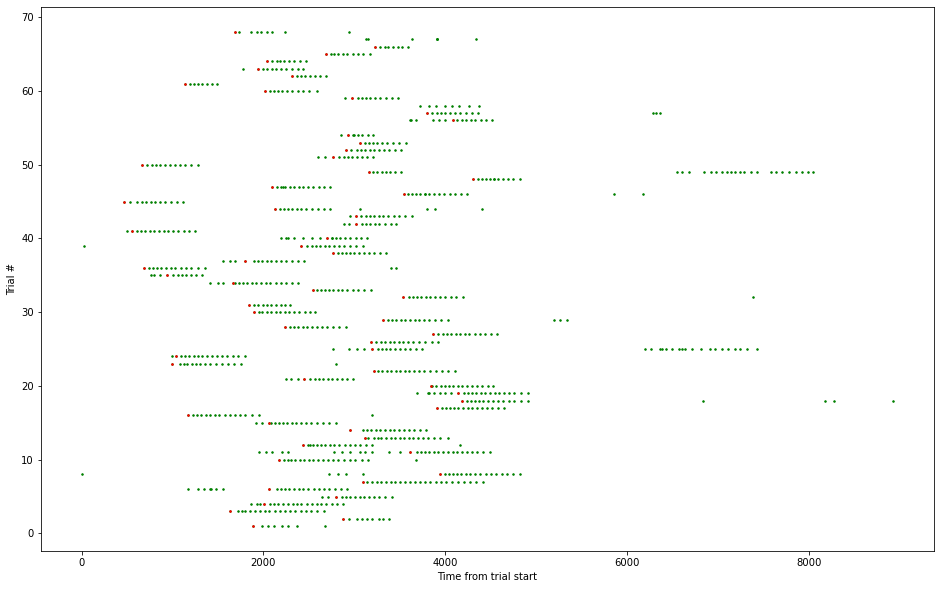

In [124]:
plt.figure(figsize=(16, 10))
for i in range(len(lt)):
    plt.plot(ltrel[i], [i]*len(ltrel[i]), 'go', markersize=1.5)    
    plt.plot(rtrel[i], [i]*len(rtrel[i]), 'ro', markersize=1.5)

plt.ylabel("Trial #")
plt.xlabel("Time from trial start")
plt.show()

In [131]:
lt = sum(lt, [])
rt = sum(rt, [])

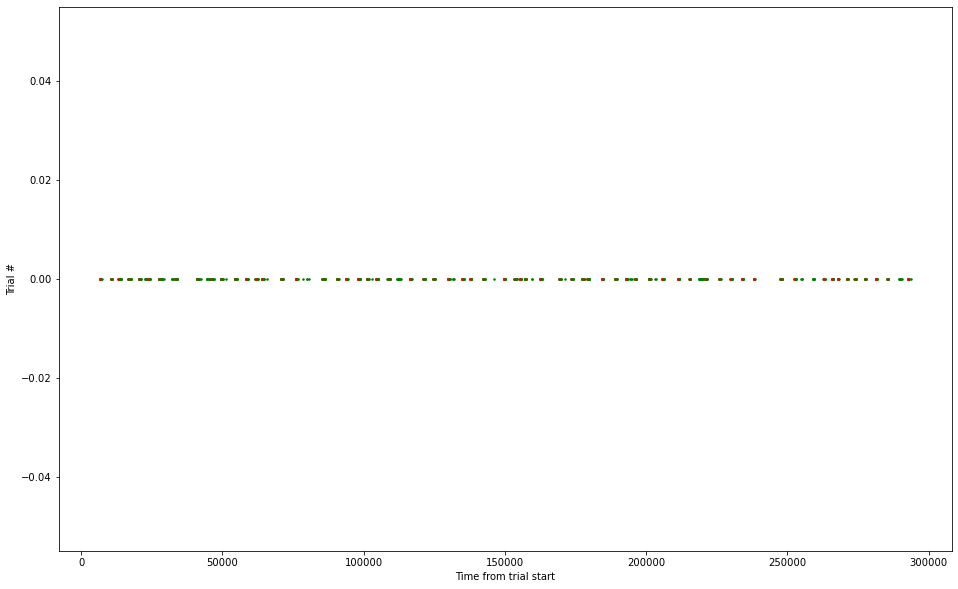

In [137]:
plt.figure(figsize=(16, 10))
# for i in range(len(lt)):
plt.plot(lt, [0]*len(lt), 'go', markersize=1.5)    
plt.plot(rt, [0]*len(rt), 'ro', markersize=1.5)

plt.ylabel("Trial #")
plt.xlabel("Time from trial start")
plt.show()

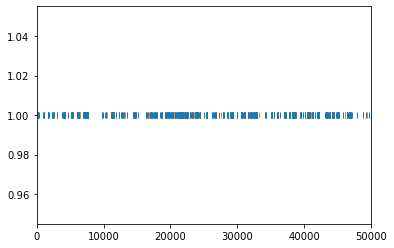

In [232]:
# import matplotlib
# matplotlib.use("qtagg")

grad = (np.gradient(dlc_data["TongueTip"]["x"]) > 50).astype('double')
grad[grad == 0.0] = np.nan
plt.plot(grad, '|')
plt.plot(rt, [1]*len(rt), '|')
plt.xlim([0, 50000])
plt.show()

In [229]:
np.cumsum(grad)

array([nan, nan, nan, ..., nan, nan, nan])

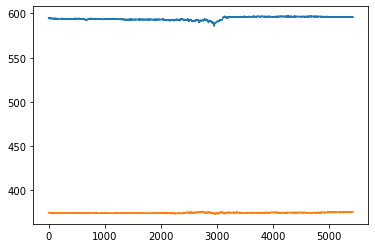

In [159]:
plt.plot(dlc_trial["PawR"]["x"])
plt.plot(dlc_trial["PawR"]["y"])
# plt.xlim([0, 500])